In [2]:
""" This chapter is on clustering algorithms.
"""

from math import sqrt


def dot(v, w):
    '''the sum of the product of the matching elements
    of the input vectors'''
    return sum(v_i * w_i for v_i,w_i in zip(v, w))


def sum_of_squares(v):
    '''add the square of each element'''
    return dot(v, v)


def vector_add(v, w):
    '''adds corresponding elements of vectors'''
    return [v_i + w_i for v_i,w_i in zip(v, w)]


def vector_subtract(v, w):
    '''subtract corresponding elements of vectors'''
    return [v_i - w_i for v_i,w_i in zip(v, w)]


def vector_sum(vectors):
    '''sum all corresponding elements'''
    result = vectors[0]
    for vector in vectors[1:]:
        result = vector_add(result, vector)

    return result


def vector_sum_fast(vectors):
    '''sum all corresponding elements'''
    return reduce(vector_add, vectors)


def scalar_multiply(c, vector):
    '''c is the scalar'''
    return [c * v_i for v_i in vector]


def vector_mean(vectors):
    '''The ith element of the result is the mean of the ith element
    of all the input vectors.'''
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))


def magnitude(v):
    '''Find the length of a vector in cartesian space'''
    return sqrt(sum_of_squares(v))


def distance(v, w):
    '''Find the distance between two vectors'''
    return magnitude(vector_subtract(v, w))


class KMeans:
    """ performs k-means clustering """
    
    def __init__(self, k):
        self.k = k
        self.means = None
    
    def classify(self, input):
        """ return the index of the cluster closest in the input """
        return min(range(self.k), key=lambda i: distance(input, self.means[i])**2)
    
    def train(self, inputs):
        """ train your means """
        # choose k random points as the initial means
        self.means = random.sample(inputs, self.k)
        assignments = None

        while True:
            # find new assignments
            new_assignments = list(map(self.classify, inputs))
            
            # if no assignments have changed, we're done
            if assignments == new_assignments:
                return
            
            # otherwise, keep the new assignments
            assignments = new_assignments
            
            # and compute the new means based on the new assignments
            for i in range(self.k):
                # find all the points assigned to center i
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                
                # divide by zero protection
                if i_points:
                    self.means[i] = vector_mean(i_points)

In [3]:
""" The meetups example """
import random
from numpy.random import randint

inputs = list(zip(randint(-25, -5, 100), randint(-25, -10, 100))) + \
         list(zip(randint(-5, 15, 100), randint(-50, -30, 100))) + \
         list(zip(randint(5, 25, 100), randint(10, 25, 100)))

clusterer = KMeans(3)
clusterer.train(inputs)
print(clusterer.means)

[[14.82, 16.280000000000001], [-15.34, -17.740000000000002], [3.0300000000000002, -40.82]]


In [4]:
clusterer2 = KMeans(2)
clusterer2.train(inputs)
print(clusterer2.means)

[[14.82, 16.280000000000001], [-6.1550000000000002, -29.280000000000001]]


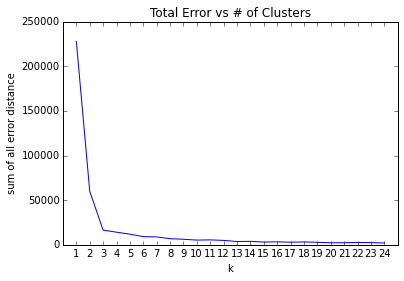

In [8]:
""" How to choose the right k for your clustering... """
%matplotlib inline
from matplotlib import pyplot as plt

def squared_clustering_errors(inputs, k):
    """ finds total squared error from k-means clustering the inputs """
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = map(clusterer.classify, inputs)
    
    return sum(distance(input, means[cluster])**2
               for input, cluster in zip(inputs, assignments))

# now plot the results of the above "error" for k = 1 to len(inputs)
#ks = range(1, len(inputs) + 1)
ks = range(1, 25)  # nevermind, I don't need that many to see the trend

errors = [squared_clustering_errors(inputs, k) for k in ks]

# make the plot
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("sum of all error distance")
plt.title("Total Error vs # of Clusters")
plt.show()

In [17]:
image_path = r"tardis_css.png"
from matplotlib import image
img = image.imread(image_path)

red, green, blue, alpha = img[0][0]  # top-left pixel
print(red, green, blue, alpha)

[ 1.  1.  1.  0.]
1.0 1.0 1.0 0.0


In [19]:
""" This is the infamous double-for list comprehension.
    Note the order the two fors have to be in:
    They read right-to-left.
"""
pixels = [pixel for row in img for pixel in row]

clusterer = KMeans(5)
clusterer.train(pixels)  # this takes a while

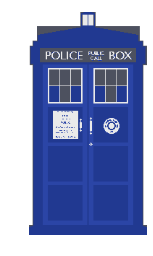

In [20]:
def recolor(pixel):
    cluster = clusterer.classify(pixel)
    return clusterer.means[cluster]

new_img = [[recolor(pixel) for pixel in row] for row in img]

plt.imshow(new_img)
plt.axis('off')
plt.show()

In [32]:
""" Bottom-Up Hierarchical Clustering
    We start with each point being in its own cluster and combine the two clusters
    that are closest together until we have just one cluster.
    As long as we save the merge order, we can back out and get any number of
    clusters we want.
"""

def is_leaf(cluster):
    """ a cluster is a leaf if it has length 1 """
    return len(cluster) == 1


def get_children(cluster):
    """ returns the two children of this cluster if it's a merged cluster;
        raises an exceptoin if it is a leaf cluster
    """
    if is_leaf(cluster):
        raise TypeError('A leaf cluster has no children.')
    else:
        return cluster[1]


def get_values(cluster):
    """ returns the value in this cluster (if it's a leaf)
        or all the values in the leaf's below (if it's not)
    """
    if is_leaf(cluster):
        return cluster
    else:
        return [value for child in get_children(cluster) for value in get_values(child)]


def cluster_distance(cluster1, cluster2, distance_agg=min):
    """ Compute all the pairwise distance between cluster1 and cluster2
        and apply _distance_agg to the resulting list.
    """
    return distance_agg([distance(input1, input2)
                         for input1 in get_values(cluster1)
                         for input2 in get_values(cluster2)])


def get_merge_order(cluster):
    """ the merge order is the 1st element of the 2-tuple """
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0]


def bottom_up_cluster(inputs, distance_agg=min):
    """ This is implements the logic for the bottom-up clustering"""
    # start with every input as a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]
    
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]],
                      key=lambda tup: cluster_distance(tup[0], tup[1], distance_agg))

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]
        
        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])
        
        # and add their merge
        clusters.append(merged_cluster)
    
    # when there's only one cluster left, return it
    return clusters[0]

In [34]:
""" Now let's use the bottom-up clustering logic we've just built. """

base_cluster = bottom_up_cluster(inputs)

In [39]:
def generate_clusters(base_cluster, num_clusters):
    """ generate the clusters N steps back from the final combined super cluster """
    clusters = [base_cluster]
    
    # as long as we don't have enough clusters
    while len(clusters) < num_clusters:
        next_cluster = min(clusters, key=get_merge_order)
        
        clusters = [c for c in clusters if c != next_cluster]
        
        clusters.extend(get_children(next_cluster))
    
    return clusters


three_cluster = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]

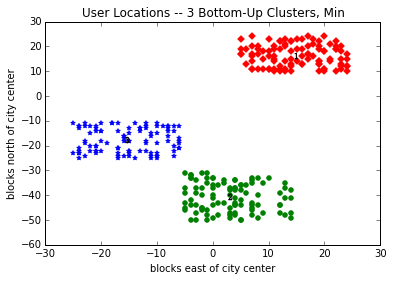

In [44]:
""" Now let's plot our new bottom-up clusters,
    and see how they compare with our K-Means cluster.
"""

for i, cluster, marker, color in zip([1,2,3], three_cluster, ['D', 'o', '*'], ['r', 'g', 'b']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    
    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
plt.title('User Locations -- 3 Bottom-Up Clusters, Min')
plt.xlabel('blocks east of city center')
plt.ylabel('blocks north of city center')
plt.show()
